In [2]:
import mne
import peakfrequency.peak_frequency as pf
from mne.channels.layout import _auto_topomap_coords as pos_from_raw
import numpy as np
import matplotlib.pyplot as plt

'''
fname = 'data/S2/S2_4chns.raw'
raw = mne.io.Raw(fname, preload=True)
data = raw.get_data()
fs = 500
channels = 4
samples = 900
data = data.T
'''
# Load data, set montage and remove bad channels as before
# Load data
path = "data/TF/"
raw = mne.io.read_raw_brainvision(path + "20191201_Cybathlon_TF_Session1_Block1.vhdr", preload=True)
# Set montage (location of channels)
raw.rename_channels({'O9': 'I1', 'O10': 'I2'})
montage = mne.channels.read_montage("standard_1005")
raw.set_montage(montage)
raw.rename_channels({'I1': 'O9', 'I2': 'O10'})
# Remove bad channels from analysis
raw.info['bads'] = ['F2', 'FFC2h', 'POO10h', 'O2']
picks = mne.pick_types(raw.info, eeg=True, stim=False, exclude='bads')


fs = int(1/raw.times[1])
# Create events from triggers
events = mne.events_from_annotations(raw)[0]
# Epoch data (cut up data into trials)
tmin = 1            # time in seconds after trigger the trial should start
tmax = tmin + 5     # time in seconds after trigger the trial should end
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, preload=True, baseline=None, picks=picks)
data_lhand = epochs['1'].get_data()
data_rhand = epochs['2'].get_data()
nr_channels = data_rhand[0].shape[0]

Extracting parameters from data/TF/20191201_Cybathlon_TF_Session1_Block1.vhdr...
Setting channel info structure...
Reading 0 ... 546359  =      0.000 ...  1092.718 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  9', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 30', 'Stimulus/S 40']
112 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 112 events and 2501 original time points ...
1 bad epochs dropped


/home/biropo/anaconda3/envs/signalprocessing/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/home/biropo/anaconda3/envs/signalprocessing/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-2-cb6eab2d57ad>:23: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Ple

In [4]:
def get_tripple(l, u, name):
    name = name+' ('+str(l)+' , '+str(u)+')'
    return float(l), float(u), name

def reset_band_bounds(bands, sub, obj, sup, l, u):
        bands[sub] = get_tripple(bands[sub][0], l, sub)
        bands[obj] = get_tripple(l, u, obj)
        bands[sup] = get_tripple(u, bands[sup][1], sup)
        return bands

def score_product(a, b):
    return a*b

def swap_score(score, best_score, lim, best_lim):
    if score > best_score:
        return score, lim
    else: 
        return best_score, best_lim

def optimize_alpha(data, bands = {'Delta': (get_tripple(1, 4,'Delta')), 'Theta': (get_tripple(4, 8,'Theta')), 'Alpha': (get_tripple(8, 12,'Alpha')), 'Beta': (get_tripple(12, 30, 'Beta')), 'Gamma': (get_tripple(30, 45,'Gamma'))}, 
                   lower=9, upper=10, lower_bound=7, upper_bound=15):
    best_score = 0
    best_lower = lower
    best_upper = upper
    while lower > lower_bound : 
        bands = reset_band_bounds(bands, 'Theta', 'Alpha', 'Beta', lower, upper)
        peakf = pf.PeakFrequency(nr_channels, samples, fs, bands)
        scores = peakf.fit(data.T)
        score = score_product(scores['Alpha'][0], scores['Alpha'][1])
        best_score, best_lower = swap_score(score, best_score, lower, best_lower)
        lower = lower-1
    best_score = 0      
    while upper < upper_bound : 
        bands = reset_band_bounds(bands, 'Theta', 'Alpha', 'Beta', lower, upper)
        peakf = pf.PeakFrequency(nr_channels, samples, fs, bands)
        scores = peakf.fit(data.T)
        score = score_product(scores['Alpha'][0], scores['Alpha'][1])
        best_score, best_upper = swap_score(score, best_score, upper, best_upper)
        upper = upper+1
        bands = reset_band_bounds(bands, 'Theta', 'Alpha', 'Beta', best_lower, best_upper)
    return bands

def get_mne_ready():
    return list(optimize_alpha().values())

print(data_rhand[0].shape)
samples = 125
bands_r = optimize_alpha(data_rhand[0,:,:125])
bands_l = optimize_alpha(data_lhand[0,:,:125])
#bands =  list(bands.values())
print(bands_r)
print(bands_l)

#&&
bands = bands_l

(122, 2501)
{'Delta': (1.0, 4.0, 'Delta (1 , 4)'), 'Theta': (4.0, 9.0, 'Theta (4.0 , 9)'), 'Alpha': (9.0, 12.0, 'Alpha (9 , 12)'), 'Beta': (12.0, 30.0, 'Beta (12 , 30.0)'), 'Gamma': (30.0, 45.0, 'Gamma (30 , 45)')}
{'Delta': (1.0, 4.0, 'Delta (1 , 4)'), 'Theta': (4.0, 9.0, 'Theta (4.0 , 9)'), 'Alpha': (9.0, 12.0, 'Alpha (9 , 12)'), 'Beta': (12.0, 30.0, 'Beta (12 , 30.0)'), 'Gamma': (30.0, 45.0, 'Gamma (30 , 45)')}


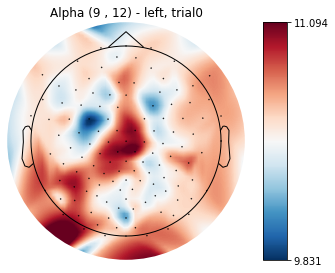

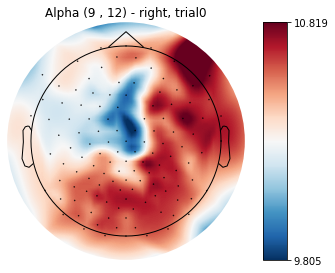

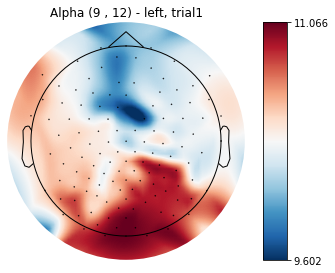

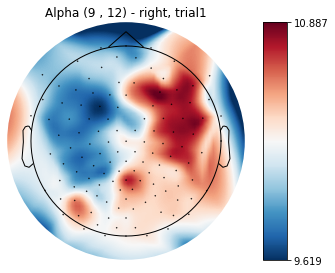

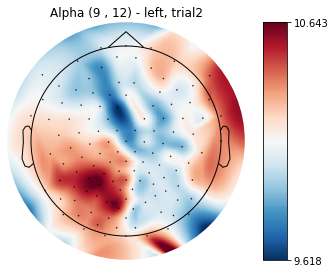

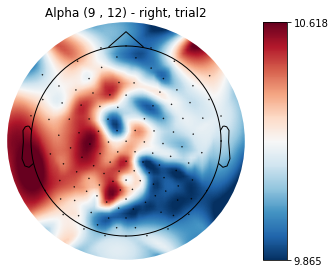

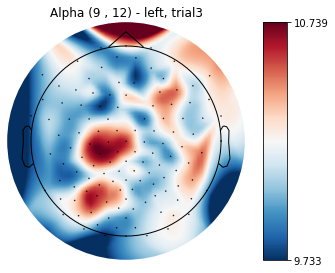

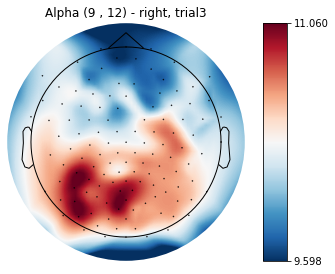

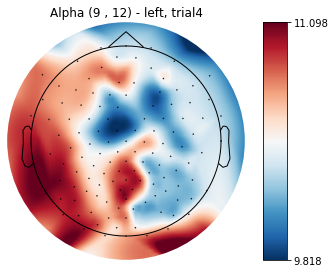

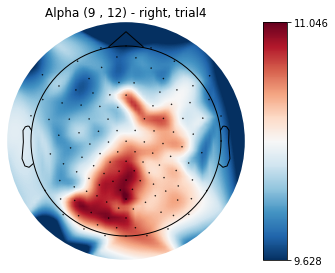

In [14]:
def plot_single_topomap(data, pos, vmin=None, vmax=None, title=None, cmap_rb=False):
    vmin = np.min(data) if vmin is None else vmin
    vmax = np.max(data) if vmax is None else vmax
    fig, ax  = plt.subplots()
    cmap = mne.viz.utils._setup_cmap('interactive', norm=1-cmap_rb)
    im, _ = mne.viz.topomap.plot_topomap(data, pos, vmin=vmin, vmax=vmax, axes=ax,
                         cmap=cmap[0], image_interp='bilinear', contours=0,
                         outlines='skirt', show=False)
    cbar, cax = mne.viz.topomap._add_colorbar(ax, im, cmap, pad=.25, title=None,
                                  size="10%", format='%3.3f')
    cbar.set_ticks((vmin, vmax))
    ax.set_title(title)


fm = pf.PeakFrequency(nr_channels, data_lhand.shape[2], fs, bands)
for i in range(data_lhand.shape[0]):
    peaks_l = fm.fit(data_lhand[i,:,:].T)
    peaks_r = fm.fit(data_rhand[i,:,:].T)
    pos = pos_from_raw(raw.info, picks)
    plot_single_topomap(peaks_l['Alpha'], pos, title = bands['Alpha'][2]+' - left, trial'+str(i), cmap_rb=True)
    plot_single_topomap(peaks_r['Alpha'], pos, title = bands['Alpha'][2]+' - right, trial'+str(i), cmap_rb=True)



